In [16]:
from pydantic import BaseModel, Field
from typing_extensions import Literal, TypedDict
from pydantic import Field
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph, START
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.document_loaders import WebBaseLoader
from typing import Annotated, List
import operator
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.types import Send
from IPython.display import Markdown, Image

from dotenv import load_dotenv

In [17]:
# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

In [18]:
class SharedState(TypedDict):
    research_topic: str
    model: ChatOpenAI
    sections: list[Section]
    section_contents: Annotated[list[str], operator.add]
    final_report: str

In [19]:
def build_model(shared_state: SharedState) -> SharedState:
    shared_state['model'] = ChatOpenAI(model="gpt-4o", temperature=0)
    return shared_state

In [20]:
def orchestrator(shared_state: SharedState) -> SharedState:
    model = shared_state['model']
    orchestrator_prompt = ChatPromptTemplate.from_template(
        "Create a detailed outline for a research report on the topic of {research_topic}. "
        "Break the report down into sections, each with a name and brief description. "
        "Limit the report to at max 5 sections."
    )

    model_with_structured_output = model.with_structured_output(Sections)
    retrieval_grader = orchestrator_prompt | model_with_structured_output
    result = retrieval_grader.invoke(
        {
            "research_topic": shared_state['research_topic'],
        }
    )
    shared_state['sections'] = [section for section in result.sections]

    return shared_state


In [21]:
def display_sections(sections: List[Section]) -> None:
    md_content = "## Report Sections\n"
    for idx, section in enumerate(sections, start=1):
        md_content += f"### Section {idx}: {section.name}\n{section.description}\n\n"
    display(Markdown(md_content))

In [22]:
load_dotenv()

shared_state = build_model({'research_topic': 'The impact of AI on modern education.'})
shared_state = orchestrator(shared_state)

display_sections(shared_state['sections'])

## Report Sections
### Section 1: Introduction to AI in Education
This section will provide an overview of artificial intelligence (AI) and its growing role in the educational sector. It will discuss the historical context, define key terms, and outline the scope of AI applications in modern education.

### Section 2: AI-Driven Learning Tools
This section will explore various AI-driven tools and platforms that are transforming the learning experience. It will cover adaptive learning systems, personalized learning environments, and intelligent tutoring systems, highlighting their benefits and challenges.

### Section 3: Impact on Teaching and Curriculum Development
This section will examine how AI is influencing teaching methodologies and curriculum design. It will discuss the integration of AI in lesson planning, assessment, and feedback, as well as the role of AI in supporting teachers and enhancing pedagogical strategies.

### Section 4: Ethical and Privacy Concerns
This section will address the ethical and privacy issues associated with the use of AI in education. It will explore concerns related to data security, student privacy, algorithmic bias, and the implications of AI decision-making in educational settings.

### Section 5: Future Prospects and Recommendations
This section will provide insights into the future of AI in education, discussing potential advancements and innovations. It will offer recommendations for educators, policymakers, and technology developers to ensure the responsible and effective integration of AI in educational systems.



In [23]:
# Worker state
class WorkerState(TypedDict):
    section: Section
    model: ChatOpenAI
    completed_sections: Annotated[list, operator.add]

In [24]:
def worker(worker_state: WorkerState) -> SharedState:
    """Worker writes a section of the report"""
    print(f"\nWorker Spawned! Working on section: {worker_state['section'].name}")
    model = worker_state['model']
    section = worker_state['section']
    # Generate section
    section = model.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {section.name} and description: {section.description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"section_contents": [section.content]}


In [25]:
# Conditional edge function to create llm_call workers that each write a section of the report
def spawn_workers(shared_state: SharedState):
    """Assign a worker to each section in the plan"""
    model = shared_state["model"]
    # Kick off section writing in parallel via Send() API
    return [
        Send("worker", {"section": section, "model": model}) 
        for section in shared_state["sections"]
    ]

In [26]:
def synthesizer(shared_state: SharedState):
    """Synthesize full report from sections"""

    # List of completed sections
    section_contents = shared_state["section_contents"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(section_contents)

    return {"final_report": completed_report_sections}


In [27]:
def build_workflow():
    # Build workflow
    orchestrator_worker_builder = StateGraph(SharedState)

    # Add the nodes
    orchestrator_worker_builder.add_node("build_model", build_model)
    orchestrator_worker_builder.add_node("orchestrator", orchestrator)
    orchestrator_worker_builder.add_node("worker", worker)
    orchestrator_worker_builder.add_node("synthesizer", synthesizer)

    # Add edges to connect nodes
    orchestrator_worker_builder.add_edge(START, "build_model")
    orchestrator_worker_builder.add_edge("build_model", "orchestrator")
    orchestrator_worker_builder.add_conditional_edges(
        "orchestrator", spawn_workers, ["worker"]
    )
    orchestrator_worker_builder.add_edge("worker", "synthesizer")
    orchestrator_worker_builder.add_edge("synthesizer", END)

    # Compile the workflow
    return orchestrator_worker_builder.compile()

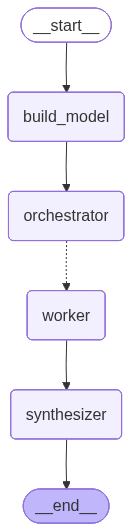

In [28]:
orchestrator_worker = build_workflow()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [29]:
state = orchestrator_worker.invoke({"research_topic": "How to prepare for a System Design technical Interview?"})

Markdown(state["final_report"])


Worker Spawned! Working on section: Introduction to System Design Interviews
Worker Spawned! Working on section: Understanding Core Concepts


Worker Spawned! Working on section: Preparation Strategies

Worker Spawned! Working on section: Common System Design Problems

Worker Spawned! Working on section: Tips for Success


## Introduction to System Design Interviews

System design interviews are a critical component of the technical interview process, particularly for roles that involve software engineering, architecture, and development. These interviews are designed to evaluate a candidate's ability to design complex systems, which is a crucial skill in the tech industry. Unlike coding interviews that focus on algorithmic problem-solving, system design interviews assess a candidate's ability to think at a higher level, considering the architecture and scalability of systems.

### Importance in the Tech Industry

In the rapidly evolving tech landscape, the ability to design robust, scalable, and efficient systems is paramount. Companies are increasingly reliant on complex software systems to deliver their services, and the demand for engineers who can architect these systems is high. System design interviews help employers identify candidates who possess the necessary skills to build and maintain these systems, ensuring they can meet current and future demands.

### Skills Assessed

System design interviews evaluate a range of skills, including:

- **Architectural Thinking**: The ability to conceptualize and design the architecture of a system, considering factors such as scalability, reliability, and performance.
- **Problem Solving**: The capacity to break down complex problems into manageable components and devise effective solutions.
- **Communication**: The skill to articulate design choices and trade-offs clearly and effectively, often collaborating with other team members.
- **Technical Knowledge**: A deep understanding of various technologies, tools, and frameworks that can be used to build systems.
- **Scalability and Performance**: The ability to design systems that can handle growth in users and data without degradation in performance.

### Setting the Stage

Understanding the context and objectives of system design interviews is essential for candidates preparing for them. These interviews are not just about finding the right answer but demonstrating a thought process that considers all aspects of system design. Candidates are expected to engage in a dialogue with the interviewer, asking clarifying questions and iterating on their designs based on feedback. This collaborative approach mirrors real-world scenarios where engineers must work together to solve complex problems.

In summary, system design interviews are a vital part of the hiring process for technical roles, assessing a candidate's ability to design systems that are both functional and scalable. By understanding the importance and skills assessed in these interviews, candidates can better prepare to showcase their abilities and secure roles in the tech industry.

---

## Understanding Core Concepts

In the realm of system design, grasping the fundamental concepts and principles is essential for creating robust, efficient, and scalable systems. This section explores these core concepts, providing a foundation for understanding how to build systems that meet the demands of modern applications.

### Scalability

Scalability refers to a system's ability to handle increased load without compromising performance. It is a critical consideration in system design, especially for applications expected to grow over time. Scalability can be achieved through vertical scaling, which involves adding more resources to a single node, or horizontal scaling, which involves adding more nodes to a system. Each approach has its trade-offs, and the choice depends on the specific requirements and constraints of the system.

### Reliability

Reliability is the measure of a system's ability to function correctly and consistently over time. It is crucial for maintaining user trust and ensuring uninterrupted service. Reliability can be enhanced through redundancy, failover mechanisms, and regular system monitoring. Designing for reliability often involves anticipating potential points of failure and implementing strategies to mitigate their impact.

### Efficiency

Efficiency in system design pertains to the optimal use of resources to achieve desired performance levels. This includes minimizing latency, maximizing throughput, and ensuring cost-effectiveness. Efficient systems are designed to perform tasks with minimal waste of computational power, memory, and other resources. Techniques such as caching, load balancing, and optimizing algorithms play a significant role in enhancing system efficiency.

### Key Components

#### Databases

Databases are integral to system design, serving as the backbone for data storage and retrieval. Choosing the right database involves considering factors such as data structure, access patterns, and scalability requirements. Relational databases, like MySQL and PostgreSQL, offer strong consistency and support complex queries, while NoSQL databases, like MongoDB and Cassandra, provide flexibility and scalability for unstructured data.

#### APIs

Application Programming Interfaces (APIs) are crucial for enabling communication between different software components. They define the methods and data formats that applications can use to interact with each other. Designing robust APIs involves ensuring they are intuitive, secure, and capable of handling varying loads. RESTful and GraphQL are popular API design paradigms, each with its strengths and use cases.

#### Load Balancers

Load balancers distribute incoming network traffic across multiple servers to ensure no single server becomes overwhelmed. They are vital for maintaining system performance and availability, especially in high-traffic environments. Load balancers can operate at different layers of the OSI model, such as Layer 4 (transport) and Layer 7 (application), each offering different capabilities and benefits.

Understanding these core concepts and components is fundamental to designing systems that are not only functional but also resilient and adaptable to future demands. By focusing on scalability, reliability, and efficiency, and leveraging key components like databases, APIs, and load balancers, system designers can create architectures that support robust and sustainable applications.

---

### Preparation Strategies

Preparing for system design interviews requires a comprehensive approach that combines theoretical knowledge with practical application. Below, we explore several strategies and resources that can help candidates effectively prepare for these challenging interviews.

#### 1. Study Design Patterns

Understanding design patterns is crucial for system design interviews. Design patterns provide reusable solutions to common problems in software design, helping candidates think critically about how to structure and organize systems. Key patterns to focus on include:

- **Singleton**: Ensures a class has only one instance and provides a global point of access.
- **Observer**: Defines a one-to-many dependency between objects so that when one object changes state, all its dependents are notified.
- **Factory**: Provides an interface for creating objects in a superclass but allows subclasses to alter the type of objects that will be created.
- **Decorator**: Adds new functionality to an existing object without altering its structure.

Candidates should familiarize themselves with these patterns and understand how they can be applied in different scenarios.

#### 2. Practice with Mock Interviews

Mock interviews are an invaluable tool for preparing for system design interviews. They simulate the interview environment, allowing candidates to practice articulating their thought processes and receive feedback. Consider the following approaches:

- **Peer Interviews**: Pair up with a fellow candidate or colleague to conduct mock interviews. This provides a low-pressure environment to practice and learn from each other.
- **Professional Services**: Utilize platforms that offer professional mock interviews with experienced interviewers who can provide detailed feedback and guidance.

#### 3. Utilize Online Platforms

Several online platforms offer resources specifically tailored for system design interview preparation. These platforms provide a range of problems, solutions, and community discussions that can enhance understanding and problem-solving skills:

- **LeetCode**: Offers a dedicated section for system design problems, complete with community solutions and discussions.
- **Educative.io**: Provides interactive courses focused on system design interviews, covering essential concepts and offering practice problems.
- **Pramp**: Facilitates peer-to-peer mock interviews, allowing candidates to practice system design questions with others preparing for similar interviews.

#### 4. Read Books on System Design

Books are a valuable resource for gaining in-depth knowledge of system design principles and best practices. Some recommended titles include:

- **"Designing Data-Intensive Applications" by Martin Kleppmann**: This book covers the fundamental principles of designing scalable and reliable systems, making it a must-read for system design interview preparation.
- **"System Design Interview – An Insider's Guide" by Alex Xu**: Offers a comprehensive guide to system design interviews, including frameworks and real-world examples.
- **"The Art of Scalability" by Martin L. Abbott and Michael T. Fisher**: Focuses on building scalable systems, providing insights into architecture and design considerations.

#### 5. Engage in Community Discussions

Participating in community discussions can provide new perspectives and insights into system design problems. Platforms like Stack Overflow, Reddit, and specialized forums offer opportunities to engage with other candidates and professionals, share knowledge, and learn from others' experiences.

By combining these strategies, candidates can build a strong foundation in system design principles and improve their ability to tackle complex design problems during interviews. Consistent practice and engagement with diverse resources will enhance both confidence and competence in system design interviews.

---

## Common System Design Problems

In system design interviews, candidates are often tasked with solving complex problems that test their ability to architect scalable and efficient systems. This section outlines some of the most common system design problems encountered during interviews, providing examples and discussing effective approaches to tackle these challenges. Emphasis is placed on the importance of clear communication and structured thinking throughout the design process.

### 1. Designing a URL Shortener

**Problem Overview:**
A URL shortener is a service that takes a long URL and converts it into a shorter, more manageable version. The system should be able to handle a large number of requests and ensure that each short URL is unique.

**Approach:**
- **Requirements Gathering:** Determine the scale of the system, including the number of URLs to be shortened and the expected read/write ratio.
- **Unique ID Generation:** Use techniques like base62 encoding or hash functions to generate unique IDs for each URL.
- **Database Design:** Choose a database that supports high read and write throughput, such as NoSQL databases like DynamoDB or Cassandra.
- **Scalability Considerations:** Implement load balancing and caching strategies to handle high traffic and reduce latency.
- **Communication:** Clearly explain each step of the design, justifying choices with trade-offs and potential bottlenecks.

### 2. Designing a Social Media Feed

**Problem Overview:**
Design a system that can generate and display a real-time feed of posts for users, similar to platforms like Facebook or Twitter.

**Approach:**
- **Feed Generation:** Decide between pull-based (client requests updates) or push-based (server sends updates) models.
- **Data Storage:** Use a distributed database to store user posts and metadata, ensuring quick access and retrieval.
- **Caching Strategy:** Implement caching layers to store frequently accessed data, reducing database load.
- **Handling Real-Time Updates:** Use message queues or streaming platforms like Kafka to manage real-time data flow.
- **Communication:** Articulate the reasoning behind choosing specific technologies and how they address scalability and latency issues.

### 3. Designing an E-commerce Platform

**Problem Overview:**
Create a system that supports an online marketplace, handling user accounts, product listings, shopping carts, and payment processing.

**Approach:**
- **Microservices Architecture:** Break down the system into independent services such as user management, product catalog, and order processing.
- **Database Design:** Use relational databases for transactional data and NoSQL databases for catalog and user data.
- **Scalability and Reliability:** Implement horizontal scaling and redundancy to ensure high availability.
- **Security Considerations:** Incorporate secure payment gateways and data encryption to protect user information.
- **Communication:** Discuss the flow of data between services and how to maintain consistency and reliability across the system.

### 4. Designing a Chat Application

**Problem Overview:**
Develop a real-time chat application that supports one-on-one and group messaging, similar to WhatsApp or Slack.

**Approach:**
- **Real-Time Communication:** Use WebSockets or long polling to enable real-time message delivery.
- **Data Storage:** Choose a database that supports high write throughput and quick retrieval, such as Redis or MongoDB.
- **Message Queuing:** Implement message queues to handle message delivery and ensure reliability.
- **Scalability:** Design the system to handle a large number of concurrent users and messages.
- **Communication:** Explain the choice of protocols and data storage solutions, focusing on how they meet the system's requirements.

### Conclusion

Addressing common system design problems requires a blend of technical knowledge, problem-solving skills, and effective communication. By approaching each problem with a structured methodology, candidates can demonstrate their ability to design robust and scalable systems. Clear articulation of design choices and trade-offs is crucial in showcasing one's understanding and capability in system design interviews.

---

## Tips for Success

Excelling in system design interviews requires a blend of technical knowledge, strategic thinking, and effective communication. Here are some practical tips to help you navigate these interviews successfully:

### 1. Master Time Management

- **Prioritize Tasks:** Begin by outlining the key components of the system. Focus on the most critical parts first, ensuring you allocate time to discuss each component thoroughly.
- **Set Milestones:** Break down the interview into phases, such as requirements gathering, high-level design, and detailed design. Allocate specific time slots for each phase to keep the discussion on track.
- **Practice Pacing:** Regularly practice mock interviews to get a feel for the timing. This will help you gauge how much time to spend on each section during the actual interview.

### 2. Handle Ambiguity with Confidence

- **Clarify Requirements:** Start by asking clarifying questions to understand the problem space fully. This demonstrates your ability to handle ambiguity and ensures you are solving the right problem.
- **Assumptions:** Clearly state any assumptions you make during the design process. This not only helps in structuring your thoughts but also shows the interviewer your ability to think critically.
- **Iterative Approach:** Be prepared to iterate on your design. If new information comes to light, show flexibility by adjusting your design accordingly.

### 3. Articulate Design Decisions Effectively

- **Structured Communication:** Use a structured approach to explain your design. Start with a high-level overview before diving into specifics. This helps the interviewer follow your thought process.
- **Rationale for Choices:** Clearly explain the reasoning behind your design choices. Discuss trade-offs and why you chose one approach over another, highlighting your decision-making skills.
- **Visual Aids:** Utilize diagrams and sketches to convey complex ideas. Visual representations can make it easier for interviewers to understand your design and follow your logic.

### 4. Demonstrate Technical Proficiency

- **Deep Dive into Components:** Be prepared to discuss any component of your design in detail. This shows your depth of knowledge and ability to handle technical challenges.
- **Stay Updated:** Keep abreast of the latest technologies and design patterns. This not only helps in crafting modern solutions but also shows your commitment to continuous learning.

### 5. Practice, Practice, Practice

- **Mock Interviews:** Regularly participate in mock interviews to simulate the pressure and dynamics of a real interview. This helps in building confidence and refining your approach.
- **Feedback Loop:** Seek feedback from peers or mentors on your performance. Constructive criticism can provide valuable insights into areas for improvement.

By focusing on these key areas, you can enhance your performance in system design interviews and increase your chances of success. Remember, the goal is not just to showcase your technical skills but also to demonstrate your ability to think critically and communicate effectively.